# import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import time

pd.set_option('display.max_columns', None)

In [ ]:
import os
path = "/content/drive/MyDrive/데마"
os.listdir(path)

['thyroidDF.csv',
 'EDA_thyroidDF.ipynb',
 'original.csv',
 'boxcox.csv',
 'log.csv',
 'Logistic.ipynb',
 'log_k2.csv',
 'log_modeling_feature_engineering2_Result.ipynb']

# training setting

In [ ]:
df = pd.read_csv(path + '/log_k2.csv')

In [ ]:
X = df.drop('target', axis=1)
y = df['target']

In [ ]:
import statsmodels.api as sm
import scipy.stats as stats

In [ ]:
# statsmodels 학습모델 구축
lr = sm.Logit(y, X)

# 모델 적합
results = lr.fit()

         Current function value: 0.216005
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# 모델정보 요약
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 7275
Model:                          Logit   Df Residuals:                     7254
Method:                           MLE   Df Model:                           20
Date:                Sat, 16 Dec 2023   Pseudo R-squ.:                  0.4186
Time:                        05:42:34   Log-Likelihood:                -1571.4
converged:                      False   LL-Null:                       -2703.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
age                     0.0039      0.003      1.488      0.137      -0.001       0.009
on_thyroxine           -1.7026      0.273     -6.228      0.000      -2.238      -1.167
query_on_thyroxine      0.1344      0.406      0.331      0.741      -0.662       0.931
on_antithyroid_meds    -0.2181      0.455     -0.480      0.632      -1.109       0.673
sick                   -0.0981      0.260     -0.377      0.706      -0.608       0.412
pregnant                2.4034      0.475      5.065      0.000       1.473       3.333
thyroid_surgery        -2.6151      0.726     -3.603      0.000      -4.038      -1.192
I131_treatment          0.2782      0.318      0.874      0.382      -0.346       0.902
query_hypothyroid       0.3708      0.173      2.147      0.032       0.032       0.709
query_hyperthyroid      1.3229      0.149      8.908      0.000       1.032       1.614
lithium                -0.4649      0.470     -0.989      0.323      -1.386       0.456
goitre                -18.8465   4568.521     -0.004      0.997   -8972.983    8935.290
tumor                   1.4900      0.247      6.035      0.000       1.006       1.974
psych                  -1.1276      0.332     -3.393      0.001      -1.779      -0.476
TSH                     2.3769      0.080     29.767      0.000       2.220       2.533
T3                      2.4834      0.252      9.869      0.000       1.990       2.977
TT4                     4.7621      0.551      8.646      0.000       3.683       5.842
T4U                   -13.9487      0.966    -14.443      0.000     -15.842     -12.056
FTI                    -4.4174      0.456     -9.688      0.000      -5.311      -3.524
sex_F                   0.0238      0.257      0.093      0.926      -0.479       0.527
sex_M                  -0.4758      0.266     -1.790      0.073      -0.997       0.045
=======================================================================================
"""

goitre는 p-value가 1에 수렴하고 표준오차가 너무 크므로 drop

In [ ]:
df = df.drop('goitre', axis=1)

In [ ]:
X = df.drop('target', axis=1)
y = df['target']

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


# VIF 계산
vif = pd.DataFrame()
vif["변수"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 결과 출력
print(vif)

                     변수   VIF Factor
0                   age     9.688530
1          on_thyroxine     1.193038
2    query_on_thyroxine     1.025288
3   on_antithyroid_meds     1.033994
4                  sick     1.050958
5              pregnant     1.052556
6       thyroid_surgery     1.020236
7        I131_treatment     1.036514
8     query_hypothyroid     1.104924
9    query_hyperthyroid     1.125683
10              lithium     1.021841
11                tumor     1.073950
12                psych     1.093668
13                  TSH     3.537953
14                   T3    37.771642
15                  TT4  3046.943946
16                  T4U   205.135846
17                  FTI  2072.206967
18                sex_F    22.800165
19                sex_M    11.555541


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

## SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5092, 20)
(727, 20)
(1456, 20)


## ROC 커브, 혼동행렬

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_custom(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 1. 원본 데이터 modeling & tuning

## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# 하이퍼파라미터 그리드 설정
param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
  {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'], 'shrinking': [False]}
]

In [ ]:
model = SVC(random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'],
                          'shrinking': [False]}],
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 100, 'kernel': 'rbf'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.85185185 0.85589226 0.85925926]
Average F1-score (Base Model): 0.8556677890011223
Base Model Training Time: 4.644653797149658 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.9004120879120879
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9756    0.9090    0.9411      1275
         1.0     0.5672    0.8398    0.6771       181

    accuracy                         0.9004      1456
   macro avg     0.7714    0.8744    0.8091      1456
weighted avg     0.9248    0.9004    0.9083      1456



## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
param_grid = {'n_neighbors': list(range(1, 31, 2)), 'weights': ['uniform', 'distance']}

In [ ]:
model = KNeighborsClassifier()

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29],
                         'weights': ['uniform', 'distance']},
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'n_neighbors': 1, 'weights': 'uniform'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.95824916 0.96026936 0.96632997]
Average F1-score (Base Model): 0.9616161616161616
Base Model Training Time: 0.6772804260253906 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.9340659340659341
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9609    0.9639    0.9624      1275
         1.0     0.7401    0.7238    0.7318       181

    accuracy                         0.9341      1456
   macro avg     0.8505    0.8438    0.8471      1456
weighted avg     0.9335    0.9341    0.9337      1456



## LR

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none']}
]

In [ ]:
model = LogisticRegression(solver='saga', random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none']}],
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 10, 'penalty': 'l2'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.81582492 0.82053872 0.82895623]
Average F1-score (Base Model): 0.821773288439955
Base Model Training Time: 0.5111377239227295 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8447802197802198
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9721    0.8471    0.9053      1275
         1.0     0.4348    0.8287    0.5703       181

    accuracy                         0.8448      1456
   macro avg     0.7034    0.8379    0.7378      1456
weighted avg     0.9053    0.8448    0.8636      1456



## NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
param_grid = {
    'alpha': np.arange(0.01, 10.02, 0.02)  # 0.01부터 10.0까지 0.02의 step으로 생성
}

In [ ]:
model = MultinomialNB()

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 501 candidates, totalling 1503 fits


GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([1.000e-02, 3.000e-02, 5.000e-02, 7.000e-02, 9.000e-02, 1.100e-01,
       1.300e-01, 1.500e-01, 1.700e-01, 1.900e-01, 2.100e-01, 2.300e-01,
       2.500e-01, 2.700e-01, 2.900e-01, 3.100e-01, 3.300e-01, 3.500e-01,
       3.700e-01, 3.900e-01, 4.100e-01, 4.300e-01, 4.500e-01, 4.700e-01,
       4.900e-01, 5.100e-01, 5.300e-01...
       9.370e+00, 9.390e+00, 9.410e+00, 9.430e+00, 9.450e+00, 9.470e+00,
       9.490e+00, 9.510e+00, 9.530e+00, 9.550e+00, 9.570e+00, 9.590e+00,
       9.610e+00, 9.630e+00, 9.650e+00, 9.670e+00, 9.690e+00, 9.710e+00,
       9.730e+00, 9.750e+00, 9.770e+00, 9.790e+00, 9.810e+00, 9.830e+00,
       9.850e+00, 9.870e+00, 9.890e+00, 9.910e+00, 9.930e+00, 9.950e+00,
       9.970e+00, 9.990e+00, 1.001e+01])},
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'alpha': 7.889999999999999}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.76902357 0.79124579 0.7969697 ]
Average F1-score (Base Model): 0.7857463524130189
Base Model Training Time: 0.14600872993469238 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8083791208791209
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9586    0.8165    0.8818      1275
         1.0     0.3676    0.7514    0.4936       181

    accuracy                         0.8084      1456
   macro avg     0.6631    0.7839    0.6877      1456
weighted avg     0.8851    0.8084    0.8336      1456



# 2. feature selection

## 전진 선택법

In [ ]:
# import statsmodels.api as sm

# def forward_selection(data, dependent_var):
#     remaining = set(data.columns)
#     remaining.remove(dependent_var)
#     selected = []
#     current_score, best_new_score = float('inf'), float('inf')
#     while remaining:
#         aic_with_candidates=[]
#         for candidate in remaining:
#             formula = "{} ~ {}".format(dependent_var,' + '.join(selected + [candidate]))
#             aic = sm.OLS.from_formula(formula, data).fit().aic
#             aic_with_candidates.append((aic, candidate))
#         aic_with_candidates.sort(reverse=True)
#         best_new_score, best_candidate=aic_with_candidates.pop()
#         if current_score > best_new_score:
#             remaining.remove(best_candidate)
#             selected.append(best_candidate)
#             current_score = best_new_score
#         else:
#             break
#     formula = "{} ~ {} ".format(dependent_var,' + '.join(selected))
#     model = sm.OLS.from_formula(formula, data).fit()
#     return model


# model = forward_selection(df, 'target')
# print(model.model.formula)
# print(model.aic)


In [ ]:
import statsmodels.api as sm

def forward_selection(data, dependent_var):
    remaining = set(data.columns)
    remaining.remove(dependent_var)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining:
        aic_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(dependent_var,' + '.join(selected + [candidate]))
            aic = sm.Logit.from_formula(formula, data).fit().aic
            aic_with_candidates.append((aic, candidate))
        aic_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = aic_with_candidates.pop()
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        else:
            break
    formula = "{} ~ {} ".format(dependent_var, ' + '.join(selected))
    model = sm.Logit.from_formula(formula, data).fit()
    return model


model = forward_selection(df, 'target')
print(model.model.formula)
print(model.aic)

Optimization terminated successfully.
         Current function value: 0.371384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370930
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368731
  

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 7275
Model:                          Logit   Df Residuals:                     7260
Method:                           MLE   Df Model:                           14
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                  0.4364
Time:                        11:22:12   Log-Likelihood:                -1523.6
converged:                       True   LL-Null:                       -2703.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -15.1146      1.388    -10.887      0.000     -17.836     -12.394
TSH                    2.5856      0.085     30.304      0.000       2.418       2.753
T3                     2.4220      0.254      9.548      0.000       1.925       2.919
query_hyperthyroid     1.3588      0.151      8.988      0.000       1.063       1.655
FTI                    3.2563      0.765      4.256      0.000       1.757       4.756
on_thyroxine          -1.7476      0.273     -6.406      0.000      -2.282      -1.213
tumor                  1.5713      0.246      6.378      0.000       1.088       2.054
thyroid_surgery       -2.6878      0.718     -3.745      0.000      -4.094      -1.281
psych                 -1.1477      0.333     -3.444      0.001      -1.801      -0.495
sex_F                  0.4467      0.112      3.988      0.000       0.227       0.666
TT4                   -2.2915      0.754     -3.039      0.002      -3.770      -0.813
pregnant               1.9078      0.462      4.132      0.000       1.003       2.813
age                    0.0066      0.003      2.497      0.013       0.001       0.012
query_hypothyroid      0.3187      0.173      1.838      0.066      -0.021       0.659
T4U                    2.4938      1.659      1.503      0.133      -0.757       5.745
======================================================================================
"""

In [ ]:
selected_features = list(model.params.index)

In [ ]:
# 얘네 빼고 선택되었다
for f in X.columns:
  if f not in selected_features:
    print(f)

query_on_thyroxine
on_antithyroid_meds
sick
I131_treatment
lithium
sex_M


In [ ]:
X_forward_selected = X.drop(['query_on_thyroxine', 'on_antithyroid_meds', 'sick', 'I131_treatment', 'lithium', 'sex_M'] , axis = 1)

### 변수 선택 후 모델링

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_forward_selected, y, test_size=0.3, random_state=42)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
X_train_resampled

,age,on_thyroxine,pregnant,thyroid_surgery,query_hypothyroid,query_hyperthyroid,tumor,psych,TSH,T3,TT4,T4U,FTI,sex_F
0,39.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.223775,1.359660,4.543295,0.688135,4.553877,0.000000
1,52.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.098612,1.029619,4.543295,0.688135,4.564348,1.000000
2,83.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.518794,1.163151,4.663439,0.638937,4.735505,1.000000
3,39.000000,0.0,0.0,0.0,1.000000,1.0,0.0,0.000000,0.182322,1.163151,4.672829,0.559616,4.955827,1.000000
4,80.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.131402,1.029619,4.653960,0.636577,4.770685,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8905,33.000000,0.0,0.0,0.0,0.949147,0.0,0.0,0.000000,2.792273,0.988804,4.351797,0.730379,4.344321,1.000000
8906,42.863557,0.0,0.0,0.0,0.136443,0.0,0.0,0.000000,4.328480,0.430342,1.396505,0.718504,1.368009,1.000000
8907,56.659052,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.108236,1.509213,5.533121,0.678162,5.562091,0.340948
8908,18.100487,0.0,0.0,0.0,0.000000,0.0,0.0,0.899513,2.533431,1.195151,4.589188,0.699388,4.582136,1.000000


### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# 하이퍼파라미터 그리드 설정
param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
  {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'], 'shrinking': [False]}
]

In [ ]:
model = SVC(random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'],
                          'shrinking': [False]}],
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 100, 'kernel': 'rbf'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.85084175 0.85690236 0.86026936]
Average F1-score (Base Model): 0.8560044893378227
Base Model Training Time: 6.198089838027954 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8997252747252747
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9756    0.9082    0.9407      1275
         1.0     0.5651    0.8398    0.6756       181

    accuracy                         0.8997      1456
   macro avg     0.7703    0.8740    0.8081      1456
weighted avg     0.9245    0.8997    0.9077      1456



### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
param_grid = {'n_neighbors': list(range(1, 31, 2)), 'weights': ['uniform', 'distance']}

In [ ]:
model = KNeighborsClassifier()

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29],
                         'weights': ['uniform', 'distance']},
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'n_neighbors': 1, 'weights': 'uniform'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.95757576 0.96363636 0.96700337]
Average F1-score (Base Model): 0.9627384960718294
Base Model Training Time: 0.5367207527160645 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.9381868131868132
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9625    0.9671    0.9648      1275
         1.0     0.7600    0.7348    0.7472       181

    accuracy                         0.9382      1456
   macro avg     0.8613    0.8509    0.8560      1456
weighted avg     0.9374    0.9382    0.9377      1456



### LR

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none']}
]

In [ ]:
model = LogisticRegression(solver='saga', random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none']}],
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 1, 'penalty': 'l1'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.82020202 0.82356902 0.82929293]
Average F1-score (Base Model): 0.8243546576879911
Base Model Training Time: 0.3451812267303467 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8475274725274725
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9722    0.8502    0.9071      1275
         1.0     0.4399    0.8287    0.5747       181

    accuracy                         0.8475      1456
   macro avg     0.7060    0.8395    0.7409      1456
weighted avg     0.9060    0.8475    0.8658      1456



### NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
param_grid = {
    'alpha': np.arange(0.01, 10.02, 0.02)  # 0.01부터 10.0까지 0.02의 step으로 생성
}

In [ ]:
model = MultinomialNB()

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 501 candidates, totalling 1503 fits


GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([1.000e-02, 3.000e-02, 5.000e-02, 7.000e-02, 9.000e-02, 1.100e-01,
       1.300e-01, 1.500e-01, 1.700e-01, 1.900e-01, 2.100e-01, 2.300e-01,
       2.500e-01, 2.700e-01, 2.900e-01, 3.100e-01, 3.300e-01, 3.500e-01,
       3.700e-01, 3.900e-01, 4.100e-01, 4.300e-01, 4.500e-01, 4.700e-01,
       4.900e-01, 5.100e-01, 5.300e-01...
       9.370e+00, 9.390e+00, 9.410e+00, 9.430e+00, 9.450e+00, 9.470e+00,
       9.490e+00, 9.510e+00, 9.530e+00, 9.550e+00, 9.570e+00, 9.590e+00,
       9.610e+00, 9.630e+00, 9.650e+00, 9.670e+00, 9.690e+00, 9.710e+00,
       9.730e+00, 9.750e+00, 9.770e+00, 9.790e+00, 9.810e+00, 9.830e+00,
       9.850e+00, 9.870e+00, 9.890e+00, 9.910e+00, 9.930e+00, 9.950e+00,
       9.970e+00, 9.990e+00, 1.001e+01])},
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'alpha': 7.329999999999998}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.7952862  0.81346801 0.81144781]
Average F1-score (Base Model): 0.8067340067340067
Base Model Training Time: 0.0321803092956543 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8351648351648352
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9592    0.8478    0.9001      1275
         1.0     0.4103    0.7459    0.5294       181

    accuracy                         0.8352      1456
   macro avg     0.6848    0.7968    0.7147      1456
weighted avg     0.8910    0.8352    0.8540      1456



## 후진 소거법

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# 모든 변수를 포함한 모델을 만듭니다.
variables = X_train_resampled.columns.tolist()
model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled[variables])).fit()

while True:
    # AIC를 계산합니다.
    max_p_value = max(model.pvalues)
    max_p_value_feature = model.pvalues.idxmax()

    # 가장 높은 AIC를 가진 변수를 제거합니다.
    if max_p_value > 0.05:
        variables.remove(max_p_value_feature)
        model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled[variables])).fit()
    else:
        break

# 최종 모델을 출력합니다.
model.summary()

Optimization terminated successfully.
         Current function value: 0.374045
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374046
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374053
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374168
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 8910
Model:                          Logit   Df Residuals:                     8893
Method:                           MLE   Df Model:                           16
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                  0.4602
Time:                        11:38:01   Log-Likelihood:                -3333.8
converged:                       True   LL-Null:                       -6175.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -16.2805      0.955    -17.042      0.000     -18.153     -14.408
age                    0.0035      0.002      1.999      0.046    6.85e-05       0.007
on_thyroxine          -2.7699      0.212    -13.078      0.000      -3.185      -2.355
sick                  -0.8849      0.193     -4.574      0.000      -1.264      -0.506
pregnant               1.2932      0.382      3.382      0.001       0.544       2.043
thyroid_surgery       -2.9622      0.441     -6.721      0.000      -3.826      -2.098
I131_treatment         0.6470      0.237      2.735      0.006       0.183       1.111
query_hyperthyroid     1.5107      0.114     13.305      0.000       1.288       1.733
lithium               -1.1871      0.335     -3.542      0.000      -1.844      -0.530
tumor                  1.2572      0.185      6.794      0.000       0.895       1.620
psych                 -1.9086      0.232     -8.224      0.000      -2.363      -1.454
TSH                    2.3878      0.053     45.252      0.000       2.284       2.491
T3                     2.9129      0.163     17.885      0.000       2.594       3.232
TT4                   -3.0380      0.540     -5.622      0.000      -4.097      -1.979
T4U                    5.1826      1.169      4.432      0.000       2.891       7.475
FTI                    4.1977      0.549      7.647      0.000       3.122       5.273
sex_F                  0.8545      0.073     11.656      0.000       0.711       0.998
======================================================================================
"""

In [ ]:
selected_features = list(model.params.index)

In [ ]:
# 얘네 빼고 선택되었다
for f in X.columns:
  if f not in selected_features:
    print(f)

query_on_thyroxine
on_antithyroid_meds
query_hypothyroid
sex_M


In [ ]:
X_backward_selected = X.drop(['query_on_thyroxine', 'on_antithyroid_meds', 'sex_M', 'query_hypothyroid'] , axis = 1)

### 변수 선택 후 모델링

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_backward_selected, y, test_size=0.3, random_state=42)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
X_train_resampled

,age,on_thyroxine,sick,pregnant,thyroid_surgery,I131_treatment,query_hyperthyroid,lithium,tumor,psych,TSH,T3,TT4,T4U,FTI,sex_F
0,39.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.223775,1.359660,4.543295,0.688135,4.553877,0.000000
1,52.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.098612,1.029619,4.543295,0.688135,4.564348,1.000000
2,83.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.518794,1.163151,4.663439,0.638937,4.735505,1.000000
3,39.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.182322,1.163151,4.672829,0.559616,4.955827,1.000000
4,80.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.131402,1.029619,4.653960,0.636577,4.770685,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8905,33.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,2.792273,0.988804,4.351797,0.730379,4.344321,1.000000
8906,42.863557,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,4.997108,0.509064,1.418368,0.791182,1.296991,0.136443
8907,57.340948,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.037232,1.456656,5.370585,0.640539,5.476953,0.340948
8908,18.100487,0.0,0.0,0.0,0.0,0.100487,0.0,0.0,0.0,0.899513,2.533431,1.195151,4.589188,0.699388,4.582136,1.000000


### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# 하이퍼파라미터 그리드 설정
param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
  {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'], 'shrinking': [False]}
]

In [ ]:
model = SVC(random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'],
                          'shrinking': [False]}],
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 100, 'kernel': 'rbf'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.85084175 0.85589226 0.85959596]
Average F1-score (Base Model): 0.8554433221099887
Base Model Training Time: 5.626264572143555 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8983516483516484
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9755    0.9067    0.9398      1275
         1.0     0.5609    0.8398    0.6726       181

    accuracy                         0.8984      1456
   macro avg     0.7682    0.8732    0.8062      1456
weighted avg     0.9240    0.8984    0.9066      1456



### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
param_grid = {'n_neighbors': list(range(1, 31, 2)), 'weights': ['uniform', 'distance']}

In [ ]:
model = KNeighborsClassifier()

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29],
                         'weights': ['uniform', 'distance']},
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'n_neighbors': 1, 'weights': 'uniform'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.95690236 0.96565657 0.96936027]
Average F1-score (Base Model): 0.9639730639730639
Base Model Training Time: 0.6122806072235107 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.9354395604395604
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9610    0.9655    0.9632      1275
         1.0     0.7486    0.7238    0.7360       181

    accuracy                         0.9354      1456
   macro avg     0.8548    0.8446    0.8496      1456
weighted avg     0.9346    0.9354    0.9350      1456



### LR

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none']}
]

In [ ]:
model = LogisticRegression(solver='saga', random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none']}],
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 1, 'penalty': 'l1'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.81851852 0.82289562 0.82861953]
Average F1-score (Base Model): 0.8233445566778901
Base Model Training Time: 0.44889116287231445 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8475274725274725
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9714    0.8510    0.9072      1275
         1.0     0.4395    0.8232    0.5731       181

    accuracy                         0.8475      1456
   macro avg     0.7054    0.8371    0.7401      1456
weighted avg     0.9052    0.8475    0.8657      1456



### NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
param_grid = {
    'alpha': np.arange(0.01, 10.02, 0.02)  # 0.01부터 10.0까지 0.02의 step으로 생성
}

In [ ]:
model = MultinomialNB()

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 501 candidates, totalling 1503 fits


GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([1.000e-02, 3.000e-02, 5.000e-02, 7.000e-02, 9.000e-02, 1.100e-01,
       1.300e-01, 1.500e-01, 1.700e-01, 1.900e-01, 2.100e-01, 2.300e-01,
       2.500e-01, 2.700e-01, 2.900e-01, 3.100e-01, 3.300e-01, 3.500e-01,
       3.700e-01, 3.900e-01, 4.100e-01, 4.300e-01, 4.500e-01, 4.700e-01,
       4.900e-01, 5.100e-01, 5.300e-01...
       9.370e+00, 9.390e+00, 9.410e+00, 9.430e+00, 9.450e+00, 9.470e+00,
       9.490e+00, 9.510e+00, 9.530e+00, 9.550e+00, 9.570e+00, 9.590e+00,
       9.610e+00, 9.630e+00, 9.650e+00, 9.670e+00, 9.690e+00, 9.710e+00,
       9.730e+00, 9.750e+00, 9.770e+00, 9.790e+00, 9.810e+00, 9.830e+00,
       9.850e+00, 9.870e+00, 9.890e+00, 9.910e+00, 9.930e+00, 9.950e+00,
       9.970e+00, 9.990e+00, 1.001e+01])},
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'alpha': 8.309999999999999}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.79461279 0.81346801 0.80606061]
Average F1-score (Base Model): 0.8047138047138048
Base Model Training Time: 0.14478397369384766 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8269230769230769
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9587    0.8384    0.8946      1275
         1.0     0.3959    0.7459    0.5172       181

    accuracy                         0.8269      1456
   macro avg     0.6773    0.7921    0.7059      1456
weighted avg     0.8888    0.8269    0.8477      1456



## Stepwise

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm


# 다중공선성을 줄이기 위해 가장 vif값이 높았던 TT4 변수 제거
X_train_resampled = X_train_resampled.drop('TT4', axis=1)

# 상수만 포함한 모델을 만듭니다.
variables = []
model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled[variables])).fit()

while True:
    changed = False

    # 사용 가능한 모든 변수에 대해 AIC를 계산하고, AIC를 가장 크게 줄이는 변수를 추가합니다.
    for feature in X_train_resampled.columns:
        if feature not in variables:
            new_variables = variables + [feature]
            new_model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled[new_variables])).fit()
            if new_model.aic < model.aic:
                model = new_model
                variables = new_variables
                changed = True

    # 모든 변수가 포함된 모델에서 AIC를 가장 크게 줄이는 변수를 제거합니다.
    for feature in variables:
        new_variables = variables.copy()
        new_variables.remove(feature)
        new_model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled[new_variables])).fit()
        if new_model.aic < model.aic:
            model = new_model
            variables = new_variables
            changed = True

    # 더 이상 변수를 추가하거나 제거할 수 없을 때까지 이 과정을 반복합니다.
    if not changed:
        break

# 최종 모델을 출력합니다.
model.summary()

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.692877
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.670673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.670615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.670467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.667224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.666933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.664789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.660388
  

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 8910
Model:                          Logit   Df Residuals:                     8894
Method:                           MLE   Df Model:                           15
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                  0.4578
Time:                        11:39:05   Log-Likelihood:                -3348.8
converged:                       True   LL-Null:                       -6175.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -12.0122      0.557    -21.559      0.000     -13.104     -10.920
age                    0.0034      0.002      1.982      0.047    3.82e-05       0.007
on_thyroxine          -2.7684      0.211    -13.103      0.000      -3.182      -2.354
sick                  -0.8887      0.193     -4.598      0.000      -1.268      -0.510
pregnant               1.3429      0.383      3.508      0.000       0.593       2.093
thyroid_surgery       -2.8001      0.435     -6.431      0.000      -3.653      -1.947
I131_treatment         0.6549      0.237      2.768      0.006       0.191       1.119
query_hyperthyroid     1.5103      0.113     13.328      0.000       1.288       1.732
lithium               -1.2040      0.334     -3.608      0.000      -1.858      -0.550
tumor                  1.2853      0.184      6.985      0.000       0.925       1.646
psych                 -1.9225      0.232     -8.280      0.000      -2.378      -1.467
TSH                    2.3805      0.053     45.309      0.000       2.278       2.483
T3                     2.8987      0.162     17.847      0.000       2.580       3.217
T4U                   -0.8788      0.449     -1.956      0.050      -1.759       0.002
FTI                    1.1602      0.085     13.587      0.000       0.993       1.328
sex_F                  0.8376      0.073     11.465      0.000       0.694       0.981
======================================================================================
"""

In [ ]:
selected_features = list(model.params.index)

In [ ]:
# 얘네 빼고 선택되었다
for f in X.columns:
  if f not in selected_features:
    print(f)

query_on_thyroxine
on_antithyroid_meds
query_hypothyroid
TT4
sex_M


In [ ]:
X_stepwise = X.drop(['query_on_thyroxine', 'on_antithyroid_meds', 'query_hypothyroid', 'TT4', 'sex_M'] , axis = 1)

### 변수 선택 후 모델링

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_stepwise, y, test_size=0.3, random_state=42)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
X_train_resampled

,age,on_thyroxine,sick,pregnant,thyroid_surgery,I131_treatment,query_hyperthyroid,lithium,tumor,psych,TSH,T3,T4U,FTI,sex_F
0,39.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.223775,1.359660,0.688135,4.553877,0.000000
1,52.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.098612,1.029619,0.688135,4.564348,1.000000
2,83.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.518794,1.163151,0.638937,4.735505,1.000000
3,39.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.182322,1.163151,0.559616,4.955827,1.000000
4,80.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.131402,1.029619,0.636577,4.770685,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8905,33.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,2.792273,0.988804,0.730379,4.344321,1.000000
8906,41.136443,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,4.092128,0.370762,0.875949,1.966581,1.000000
8907,57.340948,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.037232,1.456656,0.640539,5.476953,0.340948
8908,18.100487,0.0,0.0,0.0,0.0,0.100487,0.0,0.0,0.0,0.899513,2.533431,1.195151,0.699388,4.582136,1.000000


### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# 하이퍼파라미터 그리드 설정
param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
  {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'], 'shrinking': [False]}
]

In [ ]:
model = SVC(random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'],
                          'shrinking': [False]}],
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 1, 'kernel': 'rbf'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.85286195 0.85622896 0.86262626]
Average F1-score (Base Model): 0.8572390572390572
Base Model Training Time: 4.479530334472656 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.926510989010989
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9628    0.9529    0.9578      1275
         1.0     0.6907    0.7403    0.7147       181

    accuracy                         0.9265      1456
   macro avg     0.8267    0.8466    0.8362      1456
weighted avg     0.9289    0.9265    0.9276      1456



### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
param_grid = {'n_neighbors': list(range(1, 31, 2)), 'weights': ['uniform', 'distance']}

In [ ]:
model = KNeighborsClassifier()

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29],
                         'weights': ['uniform', 'distance']},
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'n_neighbors': 1, 'weights': 'uniform'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.95993266 0.96262626 0.96599327]
Average F1-score (Base Model): 0.9628507295173963
Base Model Training Time: 0.5240731239318848 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.9416208791208791
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9620    0.9718    0.9668      1275
         1.0     0.7857    0.7293    0.7564       181

    accuracy                         0.9416      1456
   macro avg     0.8738    0.8505    0.8616      1456
weighted avg     0.9400    0.9416    0.9407      1456



### LR

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none']}
]

In [ ]:
model = LogisticRegression(solver='saga', random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none']}],
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 100, 'penalty': 'l1'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.81986532 0.82222222 0.83097643]
Average F1-score (Base Model): 0.8243546576879911
Base Model Training Time: 0.4333837032318115 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8434065934065934
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9712    0.8463    0.9044      1275
         1.0     0.4319    0.8232    0.5665       181

    accuracy                         0.8434      1456
   macro avg     0.7015    0.8347    0.7355      1456
weighted avg     0.9042    0.8434    0.8624      1456



### NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
param_grid = {
    'alpha': np.arange(0.01, 10.02, 0.02)  # 0.01부터 10.0까지 0.02의 step으로 생성
}

In [ ]:
model = MultinomialNB()

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 501 candidates, totalling 1503 fits


GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([1.000e-02, 3.000e-02, 5.000e-02, 7.000e-02, 9.000e-02, 1.100e-01,
       1.300e-01, 1.500e-01, 1.700e-01, 1.900e-01, 2.100e-01, 2.300e-01,
       2.500e-01, 2.700e-01, 2.900e-01, 3.100e-01, 3.300e-01, 3.500e-01,
       3.700e-01, 3.900e-01, 4.100e-01, 4.300e-01, 4.500e-01, 4.700e-01,
       4.900e-01, 5.100e-01, 5.300e-01...
       9.370e+00, 9.390e+00, 9.410e+00, 9.430e+00, 9.450e+00, 9.470e+00,
       9.490e+00, 9.510e+00, 9.530e+00, 9.550e+00, 9.570e+00, 9.590e+00,
       9.610e+00, 9.630e+00, 9.650e+00, 9.670e+00, 9.690e+00, 9.710e+00,
       9.730e+00, 9.750e+00, 9.770e+00, 9.790e+00, 9.810e+00, 9.830e+00,
       9.850e+00, 9.870e+00, 9.890e+00, 9.910e+00, 9.930e+00, 9.950e+00,
       9.970e+00, 9.990e+00, 1.001e+01])},
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'alpha': 5.209999999999999}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.78619529 0.7983165  0.78855219]
Average F1-score (Base Model): 0.7910213243546579
Base Model Training Time: 0.14500713348388672 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.7973901098901099
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9579    0.8039    0.8742      1275
         1.0     0.3523    0.7514    0.4797       181

    accuracy                         0.7974      1456
   macro avg     0.6551    0.7777    0.6770      1456
weighted avg     0.8827    0.7974    0.8252      1456



# 3. feature extraction

## 전체 PCA

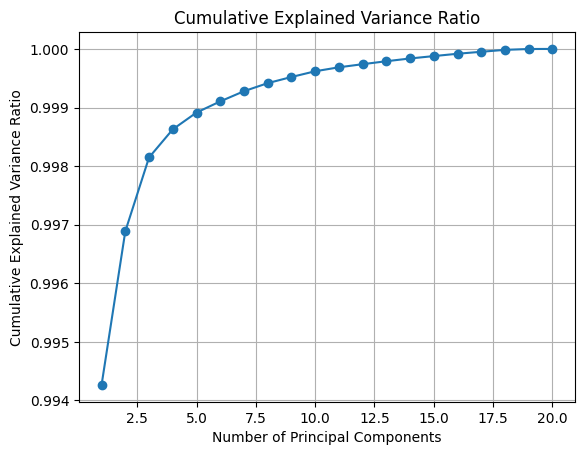

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)

# Calculate the cumulative explained variance ratio
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [ ]:
pca_target = df['target']


# PCA 적용
pca = PCA(n_components=6)  # 예시로 2개의 주성분을 선택
pca_feature = pca.fit_transform(X)

# PCA 결과를 DataFrame으로 변환
pca_df = pd.DataFrame(pca_feature, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

# 목표 변수를 PCA 결과에 추가
pca_df = pd.concat([pca_df, pca_target], axis=1)

# 결과 확인
print(pca_df)

            PC1       PC2       PC3       PC4       PC5       PC6  target
0     23.287613 -0.103365 -0.514241 -0.147496 -0.143022 -0.139468     0.0
1     24.288851 -0.428981 -0.501811  0.145533 -0.153504 -0.092418     0.0
2     24.287682 -0.041119 -0.447086  0.360255 -0.117230 -0.112433     0.0
3     24.287230  0.191479 -0.457215  0.203520 -0.115571 -0.120887     0.0
4     -1.712081 -0.066901 -0.492324 -0.232707 -0.165991 -0.111965     0.0
...         ...       ...       ...       ...       ...       ...     ...
7270 -17.712125 -0.230503 -0.424288  0.191411 -0.142144 -0.109492     0.0
7271  -3.708866 -0.620128  0.973909  0.719769 -0.155102  0.927504     0.0
7272  30.288937  0.162663  0.919256 -0.075502 -0.029572 -0.037549     0.0
7273   5.287300  0.160150 -0.420054  0.377310 -0.107273 -0.107574     0.0
7274  21.287906  0.643699  0.942483  0.247758  0.184180  0.298831     0.0

[7275 rows x 7 columns]


### train setting 다시하기

In [ ]:
X_pca = pca_df.drop('target', axis=1)
y = pca_df['target']

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y, test_size=0.3, random_state=42)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5092, 6)
(727, 6)
(1456, 6)


### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# 하이퍼파라미터 그리드 설정
param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
  {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'], 'shrinking': [False]}
]

In [ ]:
model = SVC(random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'],
                          'shrinking': [False]}],
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 100, 'kernel': 'rbf'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.83400673 0.84107744 0.84107744]
Average F1-score (Base Model): 0.8387205387205388
Base Model Training Time: 2.8121893405914307 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.9505494505494505
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9878    0.9553    0.9713      1275
         1.0     0.7444    0.9171    0.8218       181

    accuracy                         0.9505      1456
   macro avg     0.8661    0.9362    0.8965      1456
weighted avg     0.9576    0.9505    0.9527      1456



### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
param_grid = {'n_neighbors': list(range(1, 31, 2)), 'weights': ['uniform', 'distance']}

In [ ]:
model = KNeighborsClassifier()

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29],
                         'weights': ['uniform', 'distance']},
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'n_neighbors': 1, 'weights': 'uniform'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.95252525 0.95959596 0.96565657]
Average F1-score (Base Model): 0.9592592592592593
Base Model Training Time: 0.3876791000366211 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.9361263736263736
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9617    0.9655    0.9636      1275
         1.0     0.7500    0.7293    0.7395       181

    accuracy                         0.9361      1456
   macro avg     0.8559    0.8474    0.8515      1456
weighted avg     0.9354    0.9361    0.9357      1456



### LR

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none']}
]

In [ ]:
model = LogisticRegression(solver='saga', random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none']}],
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 10, 'penalty': 'l1'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.82121212 0.82962963 0.83400673]
Average F1-score (Base Model): 0.8282828282828283
Base Model Training Time: 0.21945571899414062 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8447802197802198
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9654    0.8533    0.9059      1275
         1.0     0.4316    0.7845    0.5569       181

    accuracy                         0.8448      1456
   macro avg     0.6985    0.8189    0.7314      1456
weighted avg     0.8990    0.8448    0.8625      1456



## 불필요 변수 PCA

In [ ]:
X = df.drop('target', axis=1)
y = df['target']

In [ ]:
# p-value > 0.05인 변수 추출
unsig_columns = ['age', 'query_on_thyroxine', 'on_antithyroid_meds', 'sick', 'I131_treatment', 'lithium', 'sex_F', 'sex_M']

In [ ]:
# unsig_columns에 해당하는 열 드롭
sig_X = X.drop(unsig_columns, axis=1)

# unsig_columns에 해당하는 열만 선택
unsig_X = X[unsig_columns]

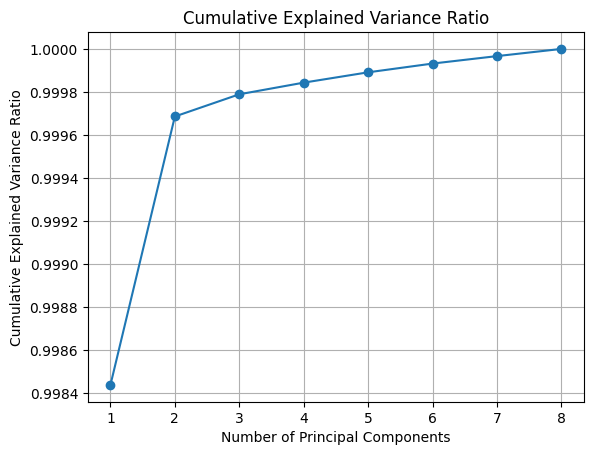

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(unsig_X)

# Calculate the cumulative explained variance ratio
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [ ]:
# PCA 적용
pca = PCA(n_components=2)
pca_feature = pca.fit_transform(unsig_X)

# PCA 결과를 DataFrame으로 변환
pca_unsig_X = pd.DataFrame(pca_feature, columns=['PC1', 'PC2'])

pca_unsig = pd.concat([sig_X, pca_unsig_X], axis=1)

# 결과 확인
pca_unsig

,on_thyroxine,pregnant,thyroid_surgery,query_hypothyroid,query_hyperthyroid,tumor,psych,TSH,T3,TT4,T4U,FTI,PC1,PC2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.955511,1.064711,4.859812,0.760413,4.778806,23.287730,-0.499534
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.530628,1.280934,4.762174,0.785743,4.638064,24.287729,-0.500627
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.788457,1.029619,4.343805,0.588157,4.610195,24.287729,-0.500627
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.064711,0.993252,4.430817,0.635414,4.584447,24.287729,-0.500627
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.064711,1.193922,4.897840,0.680565,4.770685,-1.712245,-0.472202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.758661,1.011436,4.488636,0.553885,4.787492,-17.712230,-0.454709
7271,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.138816,1.062327,4.174387,0.604316,4.356709,-3.710698,0.943990
7272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.144750,1.115007,4.521789,0.652325,4.605170,30.289269,0.906818
7273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.987041,0.915490,4.330733,0.615186,4.488636,5.287748,-0.479855


### train setting 다시하기

In [ ]:
X_pca_unsig = pca_unsig.copy()
y = df['target']

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca_unsig, y, test_size=0.3, random_state=42)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# 하이퍼파라미터 그리드 설정
param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
  {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'], 'shrinking': [False]}
]

In [ ]:
model = SVC(random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'],
                          'shrinking': [False]}],
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 100, 'kernel': 'rbf'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.83569024 0.84377104 0.84410774]
Average F1-score (Base Model): 0.8411896745230077
Base Model Training Time: 7.8263115882873535 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.9457417582417582
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9870    0.9506    0.9684      1275
         1.0     0.7237    0.9116    0.8068       181

    accuracy                         0.9457      1456
   macro avg     0.8553    0.9311    0.8876      1456
weighted avg     0.9542    0.9457    0.9483      1456



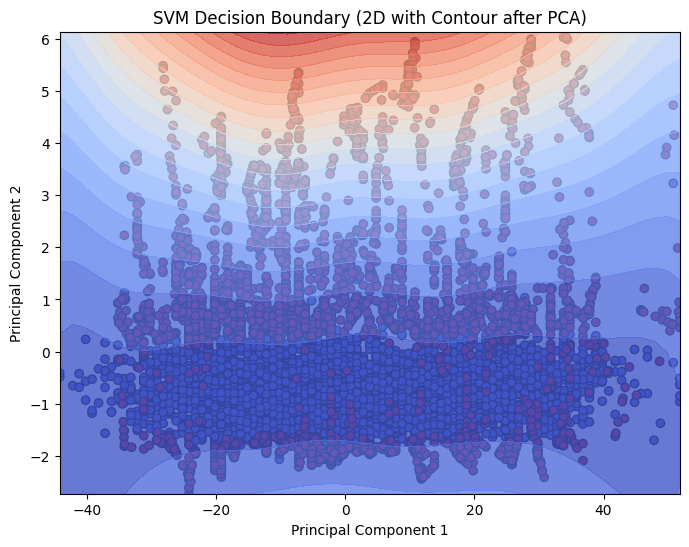

In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

# Apply PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled)

# 특성 선택을 사용하여 중요도가 높은 특성 선택
selector = SelectKBest(score_func=f_classif, k=2)
X_selected = selector.fit_transform(X_train_resampled, y_train_resampled)

# SVM 모델 학습
best_model.fit(X_pca, y_train_resampled)

# Plot the decision boundary
plt.figure(figsize=(8, 6))

# Scatter plot of data points
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_resampled, cmap=plt.cm.coolwarm, edgecolors='k')

# Decision boundary plotting
xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min(), X_pca[:, 0].max(), 50),
                     np.linspace(X_pca[:, 1].min(), X_pca[:, 1].max(), 50))
Z = best_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=20, cmap=plt.cm.coolwarm, alpha=0.8)


plt.title('SVM Decision Boundary (2D with Contour after PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

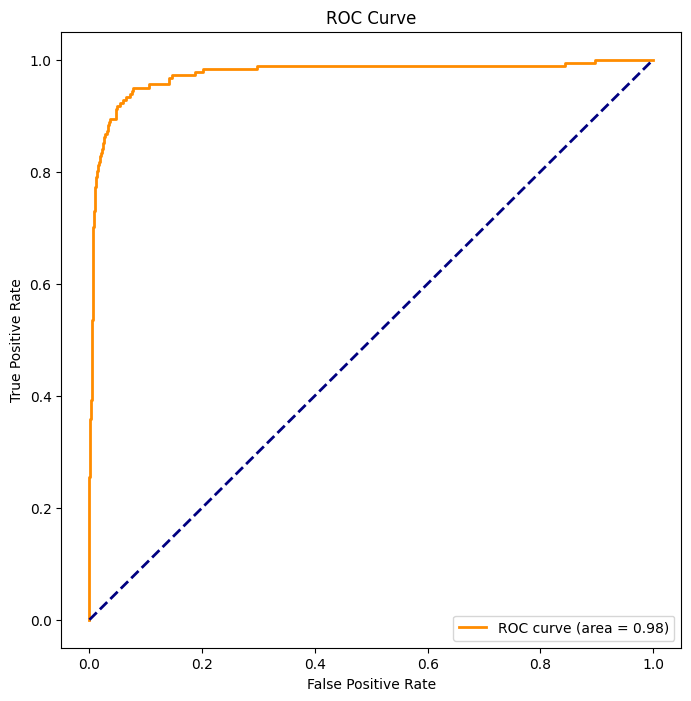

In [ ]:
from sklearn.metrics import roc_curve, auc

best_model.fit(X_train_resampled, y_train_resampled)

# 결정 함수 계산
y_score = best_model.decision_function(X_test)

# ROC 커브 계산
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


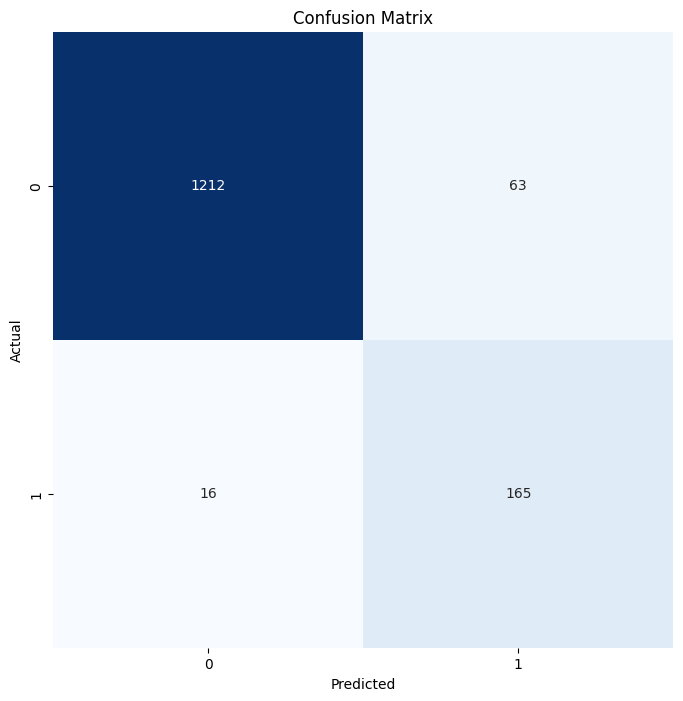

In [ ]:
plot_confusion_matrix_custom(best_model, X_test, y_test)

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
param_grid = {'n_neighbors': list(range(1, 31, 2)), 'weights': ['uniform', 'distance']}

In [ ]:
model = KNeighborsClassifier()

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29],
                         'weights': ['uniform', 'distance']},
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'n_neighbors': 1, 'weights': 'uniform'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.95555556 0.96161616 0.96835017]
Average F1-score (Base Model): 0.9618406285072952
Base Model Training Time: 0.7937896251678467 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.9388736263736264
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9640    0.9663    0.9651      1275
         1.0     0.7584    0.7459    0.7521       181

    accuracy                         0.9389      1456
   macro avg     0.8612    0.8561    0.8586      1456
weighted avg     0.9385    0.9389    0.9387      1456



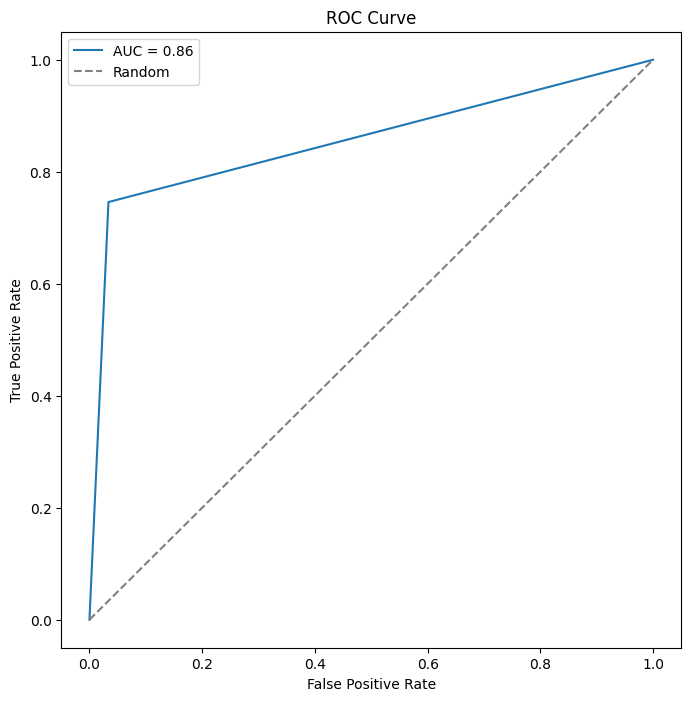

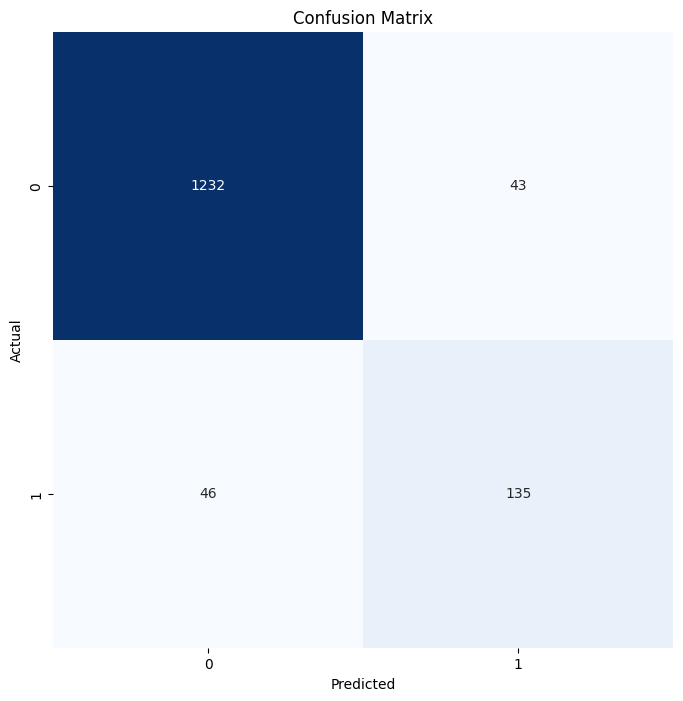

In [ ]:
plot_roc_curve(best_model, X_test, y_test)
plot_confusion_matrix_custom(best_model, X_test, y_test)

### LR

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
param_grid = [
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
  {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none']}
]

In [ ]:
model = LogisticRegression(solver='saga', random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none']}],
             scoring='f1_micro', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 0.1, 'penalty': 'l2'}


In [ ]:
# 기본 모델의 학습 시간 측정
start_time = time.time()

# 기본 모델에 대한 교차 검증 수행
base_model_f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=3, n_jobs=-1)

# 학습 시간 계산
base_model_training_time = time.time() - start_time

# 기본 모델의 교차 검증 평균 f1-score 출력
print("Base Model F1-scores:", base_model_f1_scores)
print("Average F1-score (Base Model):", base_model_f1_scores.mean())
print("Base Model Training Time:", base_model_training_time, "seconds")

Base Model F1-scores: [0.82558923 0.82895623 0.83602694]
Average F1-score (Base Model): 0.8301907968574636
Base Model Training Time: 0.8258066177368164 seconds


In [ ]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8557692307692307
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9759    0.8565    0.9123      1275
         1.0     0.4570    0.8508    0.5946       181

    accuracy                         0.8558      1456
   macro avg     0.7164    0.8536    0.7534      1456
weighted avg     0.9114    0.8558    0.8728      1456



In [ ]:
# 로지스틱 회귀 모델의 계수
coefficients = best_model.coef_[0]

# 각 특성에 대한 Odds Ratio 계산
odds_ratios = np.exp(coefficients)

# 결과를 DataFrame으로 변환
results_df = pd.DataFrame({
    'Feature': X_train_resampled.columns,  # 특성 이름은 X_train_resampled 데이터프레임의 열 이름으로 가정
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})

# 결과를 Odds Ratio 기준으로 내림차순 정렬
results_df = results_df.sort_values(by='Odds Ratio', ascending=False)

# 정렬된 결과 출력
print(results_df)

               Feature  Coefficient  Odds Ratio
8                   T3     2.342185   10.403946
7                  TSH     1.695146    5.447442
4   query_hyperthyroid     1.328056    3.773698
5                tumor     0.836664    2.308653
1             pregnant     0.435005    1.544970
11                 FTI     0.190211    1.209505
3    query_hypothyroid     0.019270    1.019457
12                 PC1    -0.004688    0.995323
9                  TT4    -0.145407    0.864671
13                 PC2    -0.611823    0.542361
2      thyroid_surgery    -0.965632    0.380743
6                psych    -1.257719    0.284302
10                 T4U    -1.793727    0.166339
0         on_thyroxine    -1.917742    0.146938


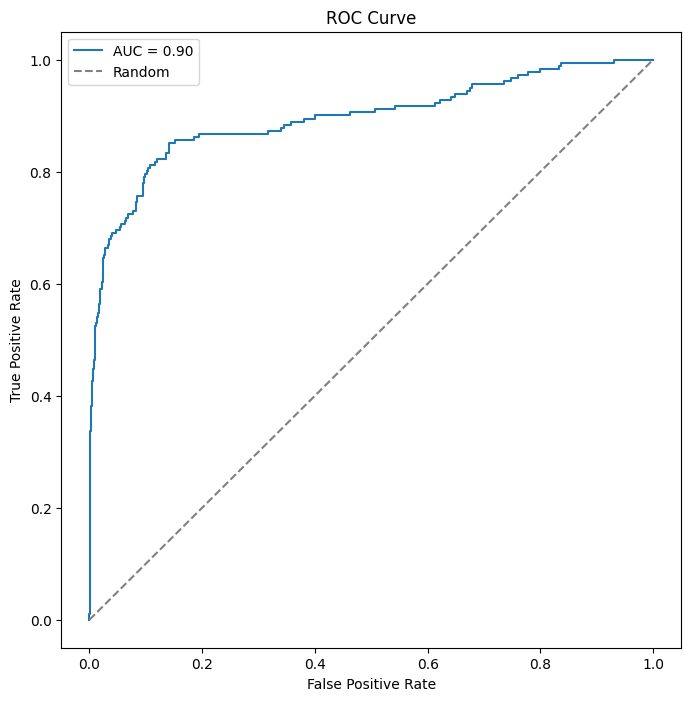

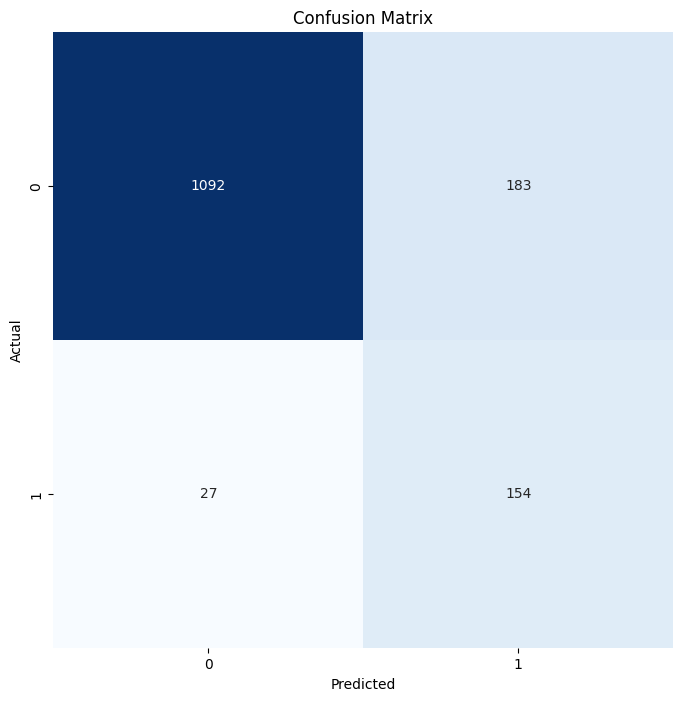

In [ ]:
plot_roc_curve(best_model, X_test, y_test)
plot_confusion_matrix_custom(best_model, X_test, y_test)